# Modeling Temperature MAX Data Geographically

In this notebook, we are using aggregated `TMAX` data by global weather stations in order to create a machine learning model to predict the daily maximum temperatures at any given latitude and longitude. Our model will take 3 continuous predictors: latitude, longitude, and elevation, and provide an estimated `TMAX` for a given day of the year.

Finally, we will show how to convert this model into a Core ML model that could be sent to an iOS or macOS device and be run on a local application.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.basemap import Basemap, maskoceans

import coremltools
import numpy as np
import pandas as pd

from tqdm import tqdm

import statsmodels.api as sm

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

/gpfs/fs01/user/sc54-455111fcadfffb-ad7b393f1eee/.local/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## The Data
The dataset was created using data from the Global Historical Climatology Network. We have averaged the `TMAX` over the entire history of each weather station for the spring and autumn equinox, and the summer and winter solstice.

In [2]:
df_data_1 = pd.read_csv("https://raw.githubusercontent.com/nwngeek212/DSX-DemoCenter/master/weatherGeographies/data_assets/seasonal_data.csv")

Let's pull out the data from Boston's Logan International Airport:

In [3]:
df_data_1[df_data_1['name'].str.contains('BOSTON LOGAN')]

,id,latitude,longitude,elevation,country,name,state,21-Mar,21-Jun,21-Sep,21-Dec
27094,USW00014739,42.3606,-71.0106,3.7,US,BOSTON LOGAN INTL AP,MA,7.690244,25.507407,21.975309,3.892593


As shown above, we have the lat-lon coordinates, and elevation data for the station. The last four columns determine the average daily maximum temperatures over the history of the station in Celsius. For example, the average `TMAX` on the 21st of June over all the recorded history for Logan Airport's weather station is 25.5$^{\circ}$C.

## The Model
Let's first split the data by columns into features and response variables, and then further into training and testing sets.

In [4]:
x = df_data_1[['latitude','longitude','elevation']]
y = df_data_1[['21-Mar','21-Jun','21-Sep','21-Dec']]

x_init, x_test, y_init, y_test = train_test_split(x, y['21-Jun'], test_size=.25)

We will fit a **Gradient Boosting Regressor** model. We should first tune our model for the hyperparameter `n_estimators` to discover what is the maximum number of estimators we should use.

In [5]:
x_train, x_val, y_train, y_val = train_test_split(x_init, y_init, test_size=.25)

Now we can iterate over a specified range to determine the best value for `n_estimators`

In [6]:
n_est = list(range(1,201))
val_mad = list()
for n in tqdm(n_est):
    val_model = GradientBoostingRegressor(n_estimators=n)
    val_model.fit(x_train,y_train)
    val_pred = val_model.predict(x_val)
    val_mad.append(mean_absolute_error(y_val,val_pred))

100%|██████████| 200/200 [01:45<00:00,  1.02s/it]


Let's plot our estimators vs. error plot to see what a good cutoff for n_estimators should be.

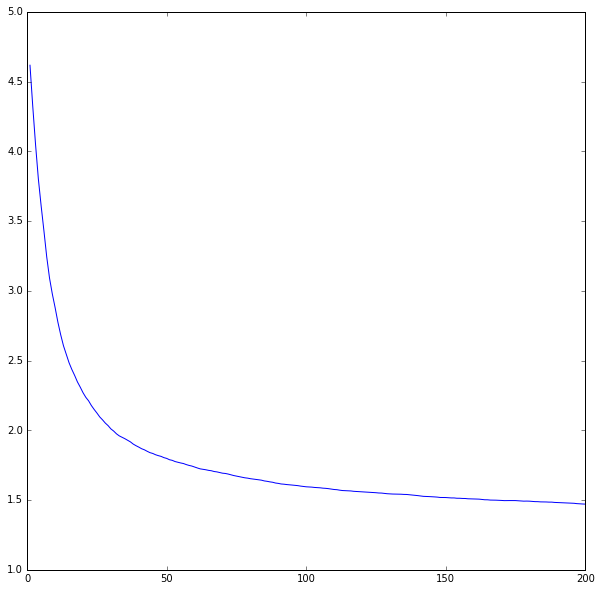

In [7]:
plt.rcParams['figure.figsize'] = (10,10)
plt.plot(n_est,val_mad)
plt.show()

### Finding the Elbow
In order to find the optimal value of `n_estimators`, we'll calculate the equation of the line between our minimum and maximum value of `n_estimators`, and find out the value of `n` in which the validation error is the furthest away from the line.

The best value of n is 32


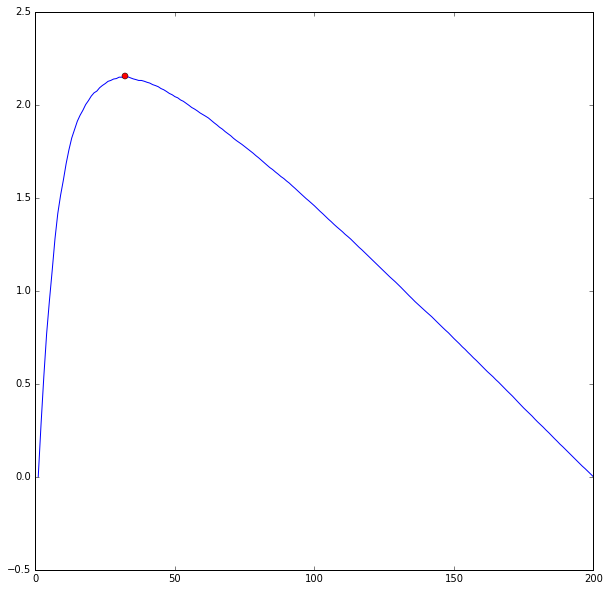

In [8]:
slope = (val_mad[-1]-val_mad[0])/(n_est[-1]-n_est[0])
intercept = val_mad[0] - slope*n_est[0]
val_diff = np.array(n_est)*slope+intercept-np.array(val_mad)
plt.plot(n_est,val_diff)

best_n = (np.array(n_est)*slope+intercept-np.array(val_mad)).argmax()
plt.plot(n_est[best_n],val_diff[best_n], 'ro')
print("The best value of n is {}".format(n_est[best_n]))
plt.show()


Using `n_estimators = 33`, we'll fit the model we'll use for prediction on the test set.

In [9]:
gbtr = GradientBoostingRegressor(n_estimators=n_est[best_n])
gbtr.fit(x_train,y_train)
y_pred = gbtr.predict(x_test)
print("Mean Absolute Error: {}\nR^2 value: {}".format(mean_absolute_error(y_pred,y_test),gbtr.score(x_test,y_test)))

Mean Absolute Error: 2.06292885311
R^2 value: 0.735021102089


Not bad! Remember that we are dealing with degrees Celsius. Our mean error in this case around 2 degrees. We also have a strong $R^2$ value.

Now let's fit the model on the entirety of the data, and then produce a grid of predicted `TMAX` values to visualize on a map.

In [10]:
gbtr.fit(x,y['21-Jun'])

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=32, presort='auto',
             random_state=None, subsample=1.0, verbose=0, warm_start=False)

## Data Visualization
Let's pull a matrix of elevation data. The data will contain elevations at latitudes [-90,90], every degree and longitudes [-180,180), every 2 degrees. We'll provide the latitude, longitude, and elevation from this matrix to create a matrix of the same size that contains predicted temperature information.

In [11]:
z = pd.DataFrame(np.empty([181,180]))
elevations = pd.read_csv("https://raw.githubusercontent.com/nwngeek212/DSX-DemoCenter/master/weatherGeographies/data_assets/elevation.csv", index_col=0)

# Make sure that the matrices are indexed by (lon,lat) values
elevations.columns = elevations.columns.astype(int)
z.columns = elevations.columns
z.index = elevations.index

Now we can fill our empty `z` matrix with the predicted temperatures.

In [12]:
for lon in range(-180,180,2):
    for lat in reversed(range(-90,91,1)):
        z[lon][lat] = gbtr.predict(pd.DataFrame({
            0: [lat],
            1: [lon],
            2: [elevations[lon][lat]]
        }))

### Plots
We'll use `matplotlib` Basemap to plot our data. We have to flip our temperature matrix, as Basemap wants 90$^{\circ}$S to be the first row in the matrix.

/gpfs/fs01/user/sc54-455111fcadfffb-ad7b393f1eee/.local/lib/python2.7/site-packages/numpy/ma/core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/gpfs/fs01/user/sc54-455111fcadfffb-ad7b393f1eee/.local/lib/python2.7/site-packages/numpy/ma/core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


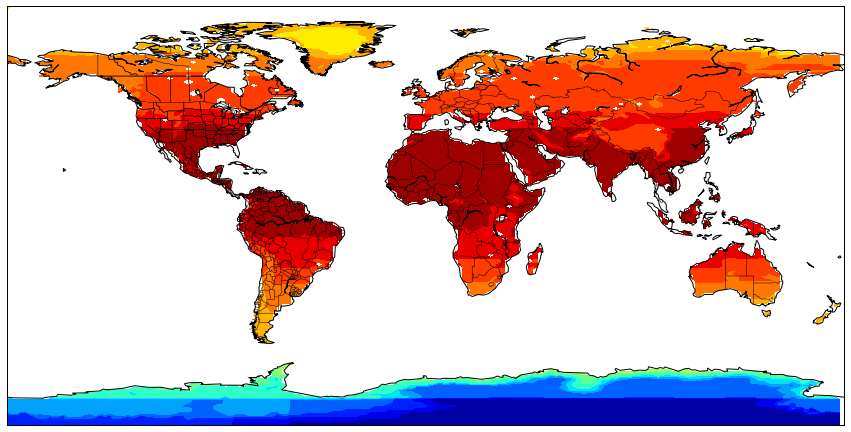

In [13]:
plt.rcParams['figure.figsize'] = (15,15)
m = Basemap()
lon, lat = np.meshgrid(list(range(-180,180,2)),list(range(-90,91,1)))
x1,y1 = m(lon,lat)
m.drawcoastlines()
m.drawstates()
m.drawcountries()
m.drawmapboundary()
z1 = maskoceans(x1,y1,np.flip(np.array(z),axis=0))
cs = m.contourf(x1,y1,z1, 15)
plt.show()

This is a fairly predictable distribution of temperatures for the 21st of June. Africa and the southern United States are scortching hot, while Antarctica is frigidly cold. Elevation data has also proved to be important, as the himalayas and tibet are marked to be colder than other regions at the same latitude, just as expected. It would be interesting to see how our map would differ if we used 21st of December data:

In [14]:
gbtr_dec = GradientBoostingRegressor(n_estimators=n_est[best_n])
gbtr_dec.fit(x,y['21-Dec'])
for lon in range(-180,180,2):
    for lat in reversed(range(-90,91,1)):
        z[lon][lat] = gbtr_dec.predict(pd.DataFrame({
            0: [lat],
            1: [lon],
            2: [elevations[lon][lat]]
        }))

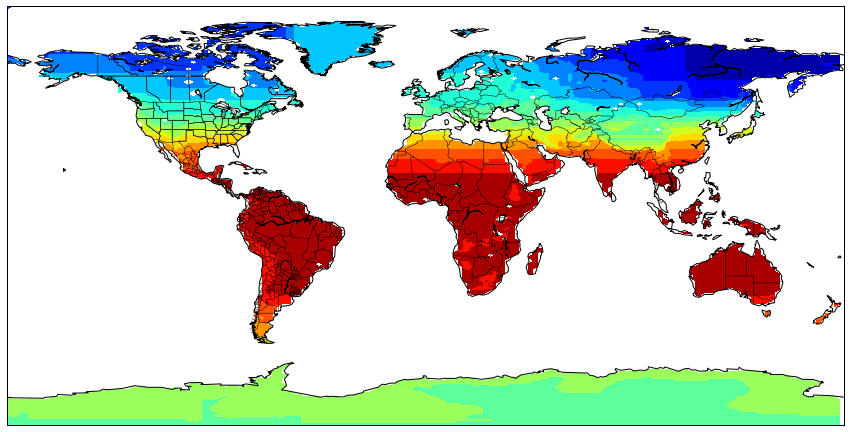

In [15]:
m = Basemap()
lon, lat = np.meshgrid(list(range(-180,180,2)),list(range(-90,91,1)))
x1,y1 = m(lon,lat)
m.drawcoastlines()
m.drawstates()
m.drawcountries()
m.drawmapboundary()
z1 = maskoceans(x1,y1,np.flip(np.array(z),axis=0))
cs = m.contourf(x1,y1,z1, 15)
plt.show()

The model has done an excellent job in estimating the temperatures on 21-Dec. As expected, the southern hemisphere is in summer, and thus hot, while North America and Europe are in Winter. 

## Convert to Core ML
If we wanted to use this model in an iOS app that could predict the weather and display it on a map, we could convert the sci-kit learn model that we created into Core ML, and then save the model as an `mlmodel` file, to be sent to an iOS developer.

In [16]:
import coremltools
jun21 = coremltools.converters.sklearn.convert(gbtr, input_features=['latitude','longitude','elevation'])
dec21 = coremltools.converters.sklearn.convert(gbtr_dec, input_features=['latitude','longitude','elevation'])

Finally save your model using the `save` function within the Core ML object

In [17]:
jun21.save('jun21.mlmodel')